In [ ]:
# necessary for DenodoConnection
#%pip install psycopg2-binary
#%pip install shap

In [2]:
# import packages
import os
import sys

import pandas as pd, numpy as np
import json
import argparse
import os

import pickle
import warnings

# need to add dme_sagemaker to path to load in libraries
sys.path.append("/root/dme_sagemaker/dme_sagemaker")

from libs.denodo.denodo_connection import DenodoConnection
import libs.performance_lib.performance_sql_recipes as performance_sql_recipes
from libs.helper.parameters_helper import ParametersHelper

from libs.performance_lib import predictive_advancement_lib
from libs.performance_lib import performance_validation_lib

import matplotlib.pyplot as plt
import boto3

from sklearn.model_selection import train_test_split

ENVIRONMENT name from config_vars: uat
DME_PROJECT name from config_vars: None


In [3]:
DKU_DST_ap_data_sector = 'SOY_BRAZIL_SUMMER'
DKU_DST_analysis_type = 'SingleExp'
input_years = ['2018','2019','2020','2021']
bucket = 'us.com.syngenta.ap.nonprod'

# convert each entry in input years to an integer since they come in as str.
if isinstance(input_years, list):
    input_years_as_int = [int(val) for val in input_years]
else:
    input_years_as_int = [int(input_years)]

In [5]:
# when testing, we read directly from S3, bucket is provided as a separate input to function, don't include in input args. 
input_args = [
    '--s3_input_pred_adv_data_folder', 'uat/dme/performance/compute_pred_adv_data_collected/data/'
]

parser = argparse.ArgumentParser(description='app inputs and outputs')
parser.add_argument('--s3_input_pred_adv_data_folder', type=str,
                    help='s3 input pred_adv_data folder', required=True)
args = parser.parse_args(input_args)

In [7]:
potential_fnames = predictive_advancement_lib.load_potential_fnames(prefix='new_')

df_input_piv = predictive_advancement_lib.load_and_preprocess_all_inputs_ml(
    args,
    DKU_DST_ap_data_sector,
    DKU_DST_analysis_type,
    potential_fnames,
    years_to_load=input_years,
    read_from_s3=1,
    bucket=bucket
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


(16617, 47)
(59292, 22)
(39831, 9)
(25595, 50)
(115212, 24)
(135214, 9)
(26769, 53)
(2938, 25)
(99076, 25)
(203857, 9)
(27413, 53)
(16357, 25)
(125592, 25)
(42, 4)
(332477, 9)


In [8]:
df_input_piv[df_input_piv['material_type'] == 'entry'][['entry_identifier','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).count()

entry_identifier
current_stage analysis_year                  
1.0           2018                        123
              2019                         82
              2020                         57
              2021                         90
2.0           2021                         96
3.0           2018                      13599
              2019                      20900
              2020                      23600
              2021                      25064
4.0           2018                       2417
              2019                       4039
              2020                        249
              2021                       1671
5.0           2018                        388
              2019                        257
              2020                         13
              2021                        244
6.0           2018                         92
              2019                        178
              2020                          8
              2021                        120
7.0           2018                        122
              2019                        263
              2020                       2976
              2021                        234

In [9]:
for col in df_input_piv.columns:
    print(col, df_input_piv[col][(df_input_piv['current_stage'] == 3) & (df_input_piv['analysis_year'] == 2022)].count())

ap_data_sector 0
analysis_year 0
entry_identifier 0
material_type 0
chkfl_EPA_R 0
chkfl_GLDGR 0
chkfl_GMSTP 0
chkfl_GWTPN 0
chkfl_HLDGR 0
chkfl_HVAPR 0
chkfl_MRTYN 0
chkfl_PDHTN 0
chkfl_PLHTN 0
chkfl_PLN_R 0
chkfl_SDS_P 0
chkfl_STD_NF 0
chkfl_YGHMN 0
chkfl_YGSMN 0
cpifl 0
result_EPA_R 0
result_GLDGR 0
result_GMSTP 0
result_GWTPN 0
result_HLDGR 0
result_HVAPR 0
result_MRTYN 0
result_PDHTN 0
result_PLHTN 0
result_PLN_R 0
result_SDS_P 0
result_STD_NF 0
result_YGHMN 0
result_YGSMN 0
result_diff_EPA_R 0
result_diff_GLDGR 0
result_diff_GMSTP 0
result_diff_GWTPN 0
result_diff_HLDGR 0
result_diff_HVAPR 0
result_diff_MRTYN 0
result_diff_PDHTN 0
result_diff_PLHTN 0
result_diff_PLN_R 0
result_diff_SDS_P 0
result_diff_STD_NF 0
result_diff_YGHMN 0
result_diff_YGSMN 0
bp_t 0
bsr_t 0
cls_t 0
cn3_t 0
dic_t 0
dpm_t 0
e3_t 0
fels_t 0
fl_ct 0
harvt 0
hilct 0
met_t 0
mi__t 0
notet 0
pb_ct 0
pd_ct 0
rps_t 0
rr2_t 0
stmtt 0
sts_t 0
material_type_simple 0
current_stage 0
next_stage 0
prev_stage 0
third_stage

In [10]:
df_input_piv[['was_adv','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).sum()

was_adv
current_stage analysis_year         
1.0           2018              15.0
              2019               0.0
              2020               8.0
              2021               0.0
2.0           2021               0.0
3.0           2018            2590.0
              2019             251.0
              2020             849.0
              2021             362.0
4.0           2018             112.0
              2019               0.0
              2020              23.0
              2021             158.0
5.0           2018              50.0
              2019               0.0
              2020               0.0
              2021              62.0
6.0           2018               0.0
              2019               0.0
              2020               0.0
              2021               0.0
7.0           2018               0.0
              2019               0.0
              2020               0.0
              2021               0.0

In [11]:
traits = ['EPA_R','GLDGR','GMSTP','GWTPN','HLDGR','HVAPR','MRTYN','PDHTN','PLHTN','PLN_R','SDS_P','STD_NF','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3)] 

df_piv[['was_adv'] + ['result_'+trait for trait in traits]].corr()

,was_adv,result_EPA_R,result_GLDGR,result_GMSTP,result_GWTPN,result_HLDGR,result_HVAPR,result_MRTYN,result_PDHTN,result_PLHTN,result_PLN_R,result_SDS_P,result_STD_NF,result_YGSMN
was_adv,1.000000,-0.059733,-0.052879,0.004291,-0.100416,-0.015589,-0.094675,0.011055,-0.001946,0.034314,-0.024841,-0.170436,0.117861,0.157927
result_EPA_R,-0.059733,1.000000,-0.006982,0.019875,-0.112024,-0.029719,0.093909,-0.022029,-0.091711,-0.001869,-0.052990,-0.268557,-0.513932,-0.231056
result_GLDGR,-0.052879,-0.006982,1.000000,0.001415,-0.077257,0.594504,0.276698,0.068278,0.021388,0.199656,-0.028822,0.724543,0.094045,-0.094302
result_GMSTP,0.004291,0.019875,0.001415,1.000000,-0.037259,0.079334,0.107569,0.000208,0.060283,0.016273,0.022511,-0.368104,-0.486877,-0.087427
result_GWTPN,-0.100416,-0.112024,-0.077257,-0.037259,1.000000,-0.010902,-0.227581,0.003923,0.167916,0.316663,0.098262,-0.522576,-0.600021,0.656513
result_HLDGR,-0.015589,-0.029719,0.594504,0.079334,-0.010902,1.000000,0.350095,0.014917,0.176196,0.270177,-0.196919,0.342999,0.169138,-0.005098
result_HVAPR,-0.094675,0.093909,0.276698,0.107569,-0.227581,0.350095,1.000000,-0.007860,-0.066177,-0.010431,-0.016315,0.027696,-0.032231,-0.183262
result_MRTYN,0.011055,-0.022029,0.068278,0.000208,0.003923,0.014917,-0.007860,1.000000,0.016888,0.041588,-0.043370,0.128134,0.009671,0.013763
result_PDHTN,-0.001946,-0.091711,0.021388,0.060283,0.167916,0.176196,-0.066177,0.016888,1.000000,0.454942,-0.227505,0.450026,-0.491778,0.148351
result_PLHTN,0.034314,-0.001869,0.199656,0.016273,0.316663,0.270177,-0.010431,0.041588,0.454942,1.000000,-0.132440,0.379809,0.617213,0.294264


In [12]:
traits = ['EPA_R','GLDGR','GMSTP','GWTPN','HLDGR','HVAPR','MRTYN','PDHTN','PLHTN','PLN_R','SDS_P','STD_NF','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3) &
                      (df_input_piv['analysis_year'] == 2019)] 

df_piv[['was_adv'] + ['result_diff_'+trait for trait in traits]].corr()

,was_adv,result_diff_EPA_R,result_diff_GLDGR,result_diff_GMSTP,result_diff_GWTPN,result_diff_HLDGR,result_diff_HVAPR,result_diff_MRTYN,result_diff_PDHTN,result_diff_PLHTN,result_diff_PLN_R,result_diff_SDS_P,result_diff_STD_NF,result_diff_YGSMN
was_adv,1.000000,-0.030437,-0.074909,0.004894,0.127067,-0.042919,-0.082360,0.028505,0.014341,0.022984,0.007407,NaN,NaN,0.128877
result_diff_EPA_R,-0.030437,1.000000,-0.034297,-0.009010,-0.145727,-0.017233,0.136023,0.036682,-0.046084,-0.078358,-0.008114,-0.350074,-0.166388,-0.147525
result_diff_GLDGR,-0.074909,-0.034297,1.000000,-0.005488,-0.054958,0.972927,0.352300,0.051367,0.010730,0.290813,-0.023181,0.108980,-0.517385,-0.054058
result_diff_GMSTP,0.004894,-0.009010,-0.005488,1.000000,0.145141,0.092220,0.157357,0.214858,0.110809,0.140278,-0.784777,-0.466330,-0.478429,-0.035535
result_diff_GWTPN,0.127067,-0.145727,-0.054958,0.145141,1.000000,-0.032620,-0.242714,0.166719,0.098475,0.217768,-0.016350,-0.461408,-0.628506,0.968530
result_diff_HLDGR,-0.042919,-0.017233,0.972927,0.092220,-0.032620,1.000000,0.405078,0.116222,0.061255,0.242111,-0.018233,-0.038159,-0.708556,-0.005642
result_diff_HVAPR,-0.082360,0.136023,0.352300,0.157357,-0.242714,0.405078,1.000000,0.027191,-0.027271,-0.043011,-0.015241,0.938504,-0.341884,-0.265496
result_diff_MRTYN,0.028505,0.036682,0.051367,0.214858,0.166719,0.116222,0.027191,1.000000,0.172751,0.245173,-0.032874,-0.356499,-0.763973,0.160468
result_diff_PDHTN,0.014341,-0.046084,0.010730,0.110809,0.098475,0.061255,-0.027271,0.172751,1.000000,0.368197,0.005907,-0.996664,-0.217564,0.077795
result_diff_PLHTN,0.022984,-0.078358,0.290813,0.140278,0.217768,0.242111,-0.043011,0.245173,0.368197,1.000000,0.001304,-0.782887,-0.343003,0.205186


In [34]:
def process_harvt(row_in):
    if isinstance(row_in,str):
        return 'drop' in row_in.lower()
    else:
        return False

#### FILTER TO DESIRED DATA for training
# filter materials: want stages 1-4, material type is parent for corn
# want stages 2-5, material type is entry for soy

df_input_piv['harvt_drop'] = df_input_piv['harvt'].apply(process_harvt)
df_piv = df_input_piv[(df_input_piv['material_type'] == 'entry') &
                      (df_input_piv['current_stage'] >= 3) &
                      (df_input_piv['current_stage'] <= 3) &
                      (df_input_piv['harvt_drop'] == False)]


#### preprocess text traits for soy
extra_traits = []
numeric_diff_traits = ['YGSMN','HLDGR','HVAPR','MRTYN','PLHTN']
numeric_raw_traits = ['STD_NF','SDS_P','EPA_R','GLDGR','GMSTP']
text_traits = [] #'pltqt','notet' at some point?

if 'decision_group' not in df_piv.columns:
    df_piv['decision_group'] = 'na'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


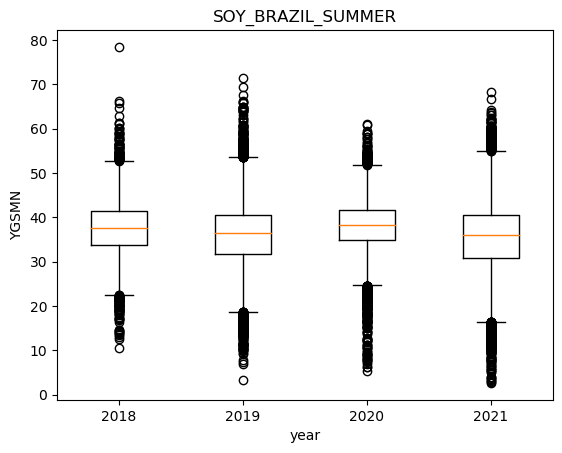

In [27]:
trait = 'result_YGSMN'

trait_data = []

for yr in input_years_as_int:
    df_yr = df_piv[(df_piv['analysis_year'] == yr)]
    trait_data.append(df_yr[df_yr[trait].notna()][trait])
    
plt.figure()
plt.boxplot(trait_data, positions=input_years_as_int);
#plt.ylim([-10,10])
plt.ylabel('YGSMN')
plt.xlabel('year')
plt.title(DKU_DST_ap_data_sector)
plt.show()

In [28]:
### train model.
grouping_cols = predictive_advancement_lib.get_grouping_cols_per_sector(analysis_sector=DKU_DST_ap_data_sector)
df_piv_grouped = df_piv.groupby(by=grouping_cols)

In [29]:
def stratified_train_test_split(df_in, out_col):
    df_tr_list = []
    df_te_list = []
    
    for out_val in pd.unique(df_in[out_col]):
        df_in_val = df_in[df_in[out_col] == out_val]
        df_tr_val, df_te_val = train_test_split(df_in_val, test_size=0.2)
        df_tr_list.append(df_tr_val)
        df_te_list.append(df_te_val)
        
    df_tr = pd.concat(df_tr_list,axis=0)
    df_te = pd.concat(df_te_list,axis=0)
    
    return df_tr, df_te


In [36]:
for index, df_use in df_piv_grouped:  # build model per unique combination of grouping_cols; stage currently
    # get model parameters for this sector and stage
    args = []
    # model parameters
    # extract inputs from args
    # get input and output column names
    mdl_in_cols = []
    mdl_in_cols.extend(['result_diff_' + trait for trait in numeric_diff_traits])
    mdl_in_cols.extend(['result_' + trait for trait in numeric_raw_traits])

    cols_to_norm = []
    mdl_out_col = 'was_adv'

    # get parameters for xgboost models
    xgb_params_class = predictive_advancement_lib.XGBoostModelParameters(
        max_depth=5,
        reg_lambda=100,
        subsample=0.2,
        learning_rate=0.005,
        n_estimators=500
    )

    # make sure each column in mdl_in col is also in the dataframe
    mdl_in_cols_use = mdl_in_cols.copy()
    for col in mdl_in_cols:
        if col not in df_use.columns:
            mdl_in_cols_use.remove(col)
    mdl_in_cols = mdl_in_cols_use
        
    # if the output var is not a boolean, this causes problems. check
    if not isinstance(df_use[mdl_out_col].dtype, bool):
        df_use[mdl_out_col] = df_use[mdl_out_col].astype(bool)

    preproc_class = predictive_advancement_lib.PredAdvPreprocessor(
        preprocess_steps=[]
    )

    mdl_class = predictive_advancement_lib.PredAdvMdl(
        params=xgb_params_class.params,
        in_cols=mdl_in_cols,
        out_col=mdl_out_col,
        weight_by_col=False
    )
  
    df_tr, df_te = stratified_train_test_split(df_use, out_col='was_adv')
    df_tr_proc = preproc_class.train_preprocessing(df_tr)
    
    # update mdl in cols based on preprocessing steps
    if 'process rm' in preproc_class.preprocess_steps:
        mdl_class.in_cols.append('rm_estimate_proc')
        # if there are dummy vars added to df_use_proc due to processing text traits, add to mdl in cols
    if 'process text traits' in preproc_class.preprocess_steps:
        new_cols = list(set(df_tr_proc.columns).difference(set(df_use.columns)))
        if 'process rm' in preproc_class.preprocess_steps:
            mdl_class.in_cols.remove('rm_estimate_proc')
        mdl_class.in_cols.extend(new_cols)
    if 'get qualifiers' in preproc_class.preprocess_steps:
        cols_to_append = df_tr_proc.columns[['qualifiers_' in col for col in df_tr_proc.columns]]
        mdl_in_cols.extend(cols_to_append)

    mdl_class.train_mdl(df_tr_proc);
    df_tr_proc['recommendation_score'] = mdl_class.predict_proba(df_tr_proc)
    df_input_stats = performance_validation_lib.compute_input_statistics(
        df_in=df_tr_proc,
        in_cols=mdl_class.in_cols
    )
    # get predictions, print metrics on training dataset (not representative of performance).
    print("Train:",index,df_tr_proc.shape,mdl_class.score(df_tr_proc, df_tr_proc[mdl_out_col].values))
    
    # some validation metrics:    
    df_te_proc = preproc_class.train_preprocessing(df_te)
    print("Test",index,df_te_proc.shape,mdl_class.score(df_te_proc, df_te_proc[mdl_out_col].values))

Train: ('SOY_BRAZIL_SUMMER', 3.0) (66529, 108) (0.8541649871325749, array([[0.82372646, 0.17627354],
       [0.11539648, 0.88460352]]), 0.9268074399976817, 0.3321362372567192)
Test ('SOY_BRAZIL_SUMMER', 3.0) (16634, 107) (0.8453314031230039, array([[0.82506478, 0.17493522],
       [0.13440197, 0.86559803]]), 0.9222048192968251, 0.32796075683251574)


Exact explainer: 1001it [11:00,  1.51it/s]                          


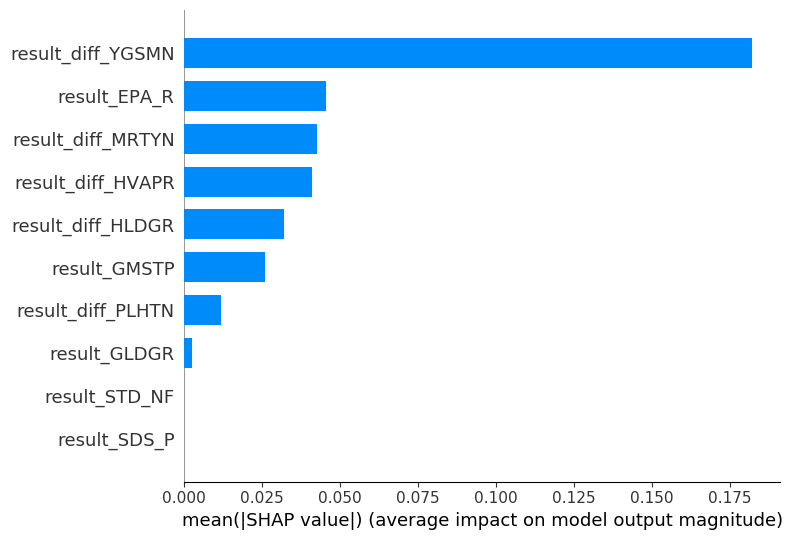

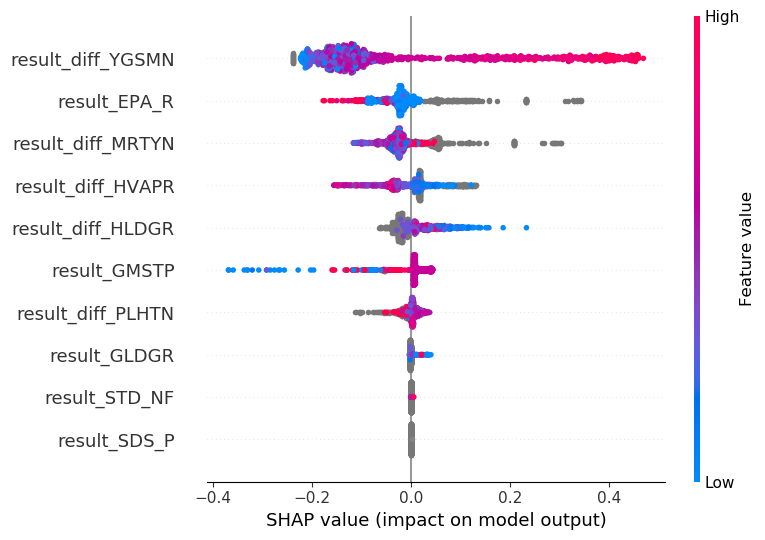

In [37]:
#shap code for new class method
# get and plot shapley values after training a model
do_shap = 1
if do_shap == 1:
    import shap
    x = df_te_proc[mdl_class.in_cols].values.astype(float)
    shap_input = shap.utils.sample(x, np.minimum(x.shape[0],1000))
    explainer = shap.Explainer(mdl_class.mdl.predict_proba, shap_input)
    shap_values = explainer(shap_input)
    shap_values = shap_values[:,:,1]

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='bar')

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='dot')

#for idx in range(len(mdl_class.in_cols)):
#    notnan_mask = np.isnan(shap_input[:,idx])==False
#    if np.sum(notnan_mask) > 10:
#        shap.plots.partial_dependence(idx,mdl_class.mdl.predict,shap_input[notnan_mask,:],ice=False,feature_names=mdl_class.in_cols)

# some useful shapley/interpolation related code
#plt.plot(shap_values[:,0].data, shap_values[:,0].values,'.')
#shap.plots.scatter(shap_values[:,5])

In [39]:
# make sure advancement columns are boolean
df_input = df_te_proc.copy()
df_input['recommendation_score'] = mdl_class.predict_proba(df_input)
if 'was_adv' in df_input.columns:
    df_input['was_adv'] = df_input['was_adv'].astype(bool)
if 'was_adv_next' in df_input.columns:
    df_input['was_adv_next'] = df_input['was_adv_next'].astype(bool)

# set trait column and yield column based on data sector
trait_prefix = 'result_' # this gets both result_ and result_diff cols
yield_col = 'result_diff_YGSMN'

# compute metrics for each stage
adv_metrics_all = []
trait_metrics_all = []

for stg in pd.unique(df_input['current_stage']):
    df_use = df_input[df_input['current_stage'] == stg]
    df_use['random_nums'] = np.random.rand(df_use.shape[0], 1)
    adv_metrics, trait_metrics = performance_validation_lib.compute_model_metrics(
        df_use,
        compute_advancement_metrics=True,
        yield_col=yield_col,
        trait_prefix=trait_prefix
    )
    adv_metrics['stage'] = stg
    trait_metrics['stage'] = stg

    adv_metrics_all.append(adv_metrics)
    trait_metrics_all.append(trait_metrics)

# join across stages
df_adv_metrics = pd.concat(adv_metrics_all,axis=0)
df_trait_metrics = pd.concat(trait_metrics_all,axis=0)

All-NaN slice encountered
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.


In [40]:
df_adv_metrics

,mdl,decision_group,metric,value,stage
0,ML,na,AUC_PR_adv,0.389694,3.0
1,ML,na,AUC_PR_notadv,0.995316,3.0
2,ML,na,TN,15390.000000,3.0
3,ML,na,FP,433.000000,3.0
4,ML,na,FN,433.000000,3.0
5,ML,na,TP,378.000000,3.0
6,ML,na,n,16634.000000,3.0
7,ML,na,perc_adv_in_bottom_75perc,0.091245,3.0
8,yield,na,AUC_PR_adv,0.190242,3.0
9,yield,na,AUC_PR_notadv,0.985404,3.0
